# <center> LAB 03: Backpropagation in Multilayer Neural Networks<br> <small>Réda DEHAK<br> 06 January 2021</small> </center>

The goal of this lab is :

    - Understand neural networks and their layered architectures,
    - Understand and implement backpropagation in `Numpy`

## Part 1: Simple Case 2D problem 
### Import Data

We will use the Wine dataset from UCI. These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of thirteen constituents found in each of the three types of wines.

# Loading and Plotting Data
 
First, we will use only two features from the data set: alcohol and ash (We can plot the solution in 2D space). The labels are supplied as an array of data with values from 1 to 3.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data.txt')

X = data[['alcohol', 'flavanoids']].to_numpy()
y = data[['class']].to_numpy().flatten() - 1

In [2]:
# split data into train and validation set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)
print('train:', len(X_train), 'test:', len(X_test))

train: 133 test: 45


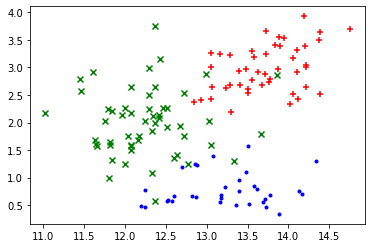

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train.flatten())

### Preprocessing

- Normalization
- Train / test split

In [4]:
from sklearn import preprocessing

# Data Normalization: mean = 0; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(scaler.scale_)

[13.00406015  2.03473684]
[0.81941941 0.96261203]


In [5]:
X_train.shape

(133, 2)

In [6]:
X_train.dtype

dtype('float64')

In [7]:
X_test.shape

(45, 2)

In [8]:
X_test.dtype

dtype('float64')

In [9]:
y_train.shape

(133,)

In [10]:
y_train.dtype

dtype('int64')

### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [11]:
def one_hot(y, n_classes):
#     rtn = []
#     if np.isscalar(y):
#         rtn = np.zeros(n_classes)
#         rtn[y] = 1
#         return rtn
#     for i in y:
#         arr = np.zeros(n_classes)
#         arr[i] = 1;
#         rtn.append(arr)
#     return rtn
    return np.eye(n_classes)[y]

    

In [12]:
from tensorflow.keras.utils import to_categorical
to_categorical(y=3, num_classes=5)

array([0., 0., 0., 1., 0.], dtype=float32)

In [13]:
one_hot(y=3, n_classes=5)

array([0., 0., 0., 1., 0.])

In [14]:
to_categorical(y=[0, 4, 9, 1], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [15]:
one_hot(y=[0, 4, 9, 1], n_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [16]:
def softmax(X):
    y = np.exp(X)
    y = y / np.sum(y, axis = -1, keepdims = True)
    return y

Make sure that this works one vector at a time (and check that the components sum to one):

In [17]:
print(softmax([10, 2, -3]))
print(np.sum(softmax([10, 2, -3])))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]
1.0


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [18]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))
print(np.sum(softmax(X), axis=-1))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]
[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [19]:
EPS = 1E-5
def nllk(Y_true, Y_pred):
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)
    llk = np.sum(np.log(EPS + Y_pred) * Y_true, axis=1)
    return -np.mean(llk)


# Make sure that it works for a simple sample at a time
print(nllk([1, 0, 0], [.99, 0.01, 0]))

0.010040234894415344


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [20]:
print(nllk([1, 0, 0], [0.01, 0.01, .98]))

4.604170685655008


Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

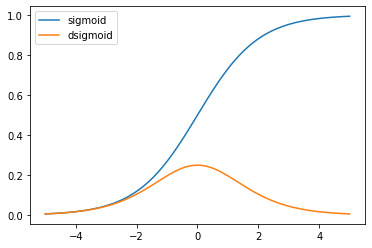

In [21]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))


def dsigmoid(X):
    t = sigmoid(X)
    return t * (1 - t)

x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid\left(\mathbf{W}_h^T \hat{\mathbf{x}}\right)$
  - $\mathbf{y} = softmax\left(\mathbf{W}_o^T \hat{\mathbf{h}}\right)$

- Notes: 
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- Implement the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

In [32]:
EPSILON = 1e-8


class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size + 1, hidden_size), high=0.01, low=-0.01)
        self.W_o = np.random.uniform(size=(hidden_size + 1,output_size), high=0.01, low=-0.01)
        self.output_size = output_size
        
    def forward(self, X):
        X = np.atleast_2d(X)
        In_h = np.insert(X.T, 0, np.ones(len(X)), axis=0)
        z_h = self.W_h.T @ In_h
        O_h = sigmoid(z_h)
        
        In_o = np.insert(O_h, 0, np.ones(O_h.shape[1]), axis=0)
        z_o = self.W_o.T @ In_o
        O = softmax(z_o.T)
        
        return O
    
    def forward_keep_activations(self, X):
        X = np.atleast_2d(X)
        In_h = np.insert(X.T, 0, np.ones(len(X)), axis=0)
        z_h = self.W_h.T @ In_h
        O_h = sigmoid(z_h)
        
        In_o = np.insert(O_h, 0, np.ones(O_h.shape[1]), axis=0)
        z_o = self.W_o.T @ In_o
        O = softmax(z_o.T)
        
        return In_h, In_o, O, O_h.T, z_h.T, z_o.T
    
    def loss(self, X, y):
        return nllk(one_hot(y, n_classes=self.output_size), self.forward(X))

    def grad_loss(self, x, y_true):
        In_h, In_o, O, O_h, z_h, z_o = self.forward_keep_activations(x)
        d_o = 2 * (O - one_hot(y_true,n_classes=self.output_size)) * dsigmoid(z_o)
        
        dEdW_o = In_o @ d_o
        
        W = np.delete(self.W_o, 0, axis=0)
        d_h = (dsigmoid(z_h).T * (W @ d_o.T)).T
        
        dEdW_h = In_h @ d_h

        return {"dEdW_h": dEdW_h, "dEdW_o": dEdW_o}

    
    def train(self, x, y, learning_rate, l2 = 0.):
        # One step of Backpropagation on x
        # l2 is the L2 regularization coefficient 
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * (grads["dEdW_h"])
        self.W_o = self.W_o - learning_rate * (grads["dEdW_o"])

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Use the class NeuralNet to train a classifier on Wine Dataset, try different values for n_hidden (1,2,3 and 5), different Learning rate (0.1, 1, .5 and .01) and different l2 (0, 0.001, 0.005, 0.01) see the difference

In [33]:
n_hidden = 3
n_features = 2
n_classes = 3
model = NeuralNet(n_features, n_hidden, n_classes)

In [34]:
model.loss(X_train, y_train)

1.099415316923176

In [35]:
model.accuracy(X_train, y_train)

0.24812030075187969

In [36]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    
    for i in np.arange(X_train.shape[0]):
        model.train(X_train[i, :], y_train[i], .1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 1.09942, train acc: 0.248, test acc: 0.333
Epoch #1, train loss: 1.07891, train acc: 0.406, test acc: 0.378
Epoch #2, train loss: 1.07606, train acc: 0.406, test acc: 0.378
Epoch #3, train loss: 1.06812, train acc: 0.406, test acc: 0.378
Epoch #4, train loss: 1.04480, train acc: 0.406, test acc: 0.378
Epoch #5, train loss: 0.97761, train acc: 0.414, test acc: 0.400
Epoch #6, train loss: 0.84015, train acc: 0.677, test acc: 0.600
Epoch #7, train loss: 0.68333, train acc: 0.842, test acc: 0.711
Epoch #8, train loss: 0.56478, train acc: 0.865, test acc: 0.844
Epoch #9, train loss: 0.48457, train acc: 0.872, test acc: 0.844
Epoch #10, train loss: 0.42957, train acc: 0.910, test acc: 0.867
Epoch #11, train loss: 0.39057, train acc: 0.910, test acc: 0.867
Epoch #12, train loss: 0.36198, train acc: 0.917, test acc: 0.911
Epoch #13, train loss: 0.34035, train acc: 0.910, test acc: 0.911
Epoch #14, train loss: 0.32354, train acc: 0.910, test acc: 0.911
Epoch #15, train 

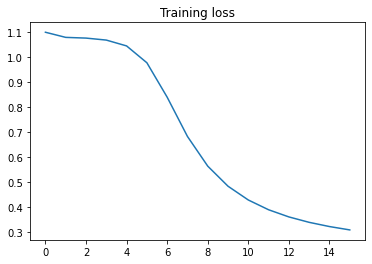

In [37]:
plt.plot(losses)
plt.title("Training loss");

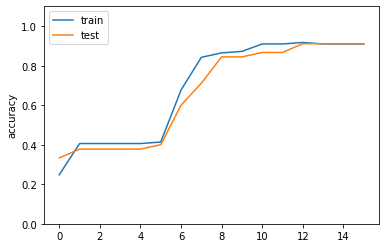

In [38]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

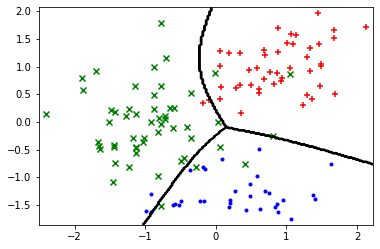

In [39]:
def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)
    plt.contour(xs, ys, zs, colors='black')

plot_points(X_train, y_train.flatten())
plot_boundary(X_train, lambda x: model.predict(x))

### Mini-batches

In [41]:
n_hidden = 4
lr = 0.1
batch_size = 20

model = NeuralNet(n_features, n_hidden, n_classes)

losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

N = X_train.shape[0]
for epoch in range(100):
    indices = np.random.permutation(N)
    
    for start_idx in range (0, N, batch_size):
        batch_idx = indices[start_idx:min(start_idx + batch_size,N)]
        model.train(X_train[batch_idx, :], y_train[batch_idx], .1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 1.09893, train acc: 0.248, test acc: 0.333
Epoch #1, train loss: 1.08747, train acc: 0.346, test acc: 0.289
Epoch #2, train loss: 1.08339, train acc: 0.346, test acc: 0.289
Epoch #3, train loss: 1.07447, train acc: 0.406, test acc: 0.378
Epoch #4, train loss: 1.05104, train acc: 0.489, test acc: 0.467
Epoch #5, train loss: 0.99966, train acc: 0.496, test acc: 0.467
Epoch #6, train loss: 0.91374, train acc: 0.910, test acc: 0.867
Epoch #7, train loss: 0.73449, train acc: 0.759, test acc: 0.689
Epoch #8, train loss: 0.59250, train acc: 0.850, test acc: 0.711
Epoch #9, train loss: 0.50841, train acc: 0.917, test acc: 0.889
Epoch #10, train loss: 0.44008, train acc: 0.887, test acc: 0.867
Epoch #11, train loss: 0.40385, train acc: 0.880, test acc: 0.822
Epoch #12, train loss: 0.36868, train acc: 0.925, test acc: 0.911
Epoch #13, train loss: 0.34464, train acc: 0.925, test acc: 0.911
Epoch #14, train loss: 0.32523, train acc: 0.917, test acc: 0.867
Epoch #15, train 

Le batch a besoin plus de iteration pour converger. Mais le batch est très utilisé grâce ai calcul vectoriel des cartes graphiques

## Part2: Digit Dataset

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

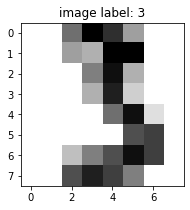

In [43]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [44]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(scaler.scale_)

[0.00000000e+00 2.98624754e-01 5.19253438e+00 1.18428291e+01
 1.18565815e+01 5.81008513e+00 1.34774067e+00 1.19187950e-01
 6.54878847e-03 1.99345121e+00 1.03464309e+01 1.19305828e+01
 1.02626064e+01 8.20497708e+00 1.84348396e+00 9.88867060e-02
 3.27439424e-03 2.61624100e+00 9.83497053e+00 6.87098887e+00
 7.11263916e+00 7.83759005e+00 1.75376555e+00 4.45317616e-02
 1.30975769e-03 2.48788474e+00 9.04453176e+00 8.73280943e+00
 9.98231827e+00 7.57105435e+00 2.26850033e+00 2.61951539e-03
 0.00000000e+00 2.36149312e+00 7.68369352e+00 9.07924034e+00
 1.03713163e+01 8.79240341e+00 2.89980354e+00 0.00000000e+00
 8.51342502e-03 1.57039948e+00 6.84937787e+00 7.22855272e+00
 7.65029470e+00 8.26522593e+00 3.48592010e+00 2.61951539e-02
 8.51342502e-03 6.83693517e-01 7.49312377e+00 9.56516045e+00
 9.36869679e+00 8.77668631e+00 3.76686313e+00 2.08906352e-01
 6.54878847e-04 2.78978389e-01 5.53700065e+00 1.20595940e+01
 1.17832351e+01 6.81990832e+00 2.07465619e+00 3.42501637e-01]
[1.         0.91047426 

In [45]:
X_train.shape

(1527, 64)

In [46]:
X_train.dtype

dtype('float32')

In [47]:
X_test.shape

(270, 64)

In [48]:
X_test.dtype

dtype('float32')

In [49]:
y_train.shape

(1527,)

In [50]:
y_train.dtype

dtype('int32')

In [51]:
n_hidden = 10
n_classes = 10
n_features = 64
model = NeuralNet(n_features, n_hidden, n_classes)

In [52]:
model.loss(X_train, y_train)

2.3028837281856593

In [53]:
model.accuracy(X_train, y_train)

0.10870988867059594

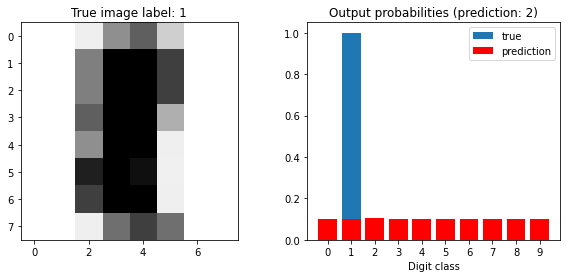

In [53]:
def plot_prediction(model, sample_idx = 0, classes = range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8), cmap = plt.cm.gray_r,
               interpolation = 'nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(y_test[sample_idx],len(classes)), label = 'true')
    ax1.bar(classes, model.forward(X_test[sample_idx]).ravel(), label = 'prediction', color = "red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(model, sample_idx=5)

In [54]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30288, train acc: 0.097, test acc: 0.107
Epoch #1, train loss: 0.98903, train acc: 0.792, test acc: 0.756
Epoch #2, train loss: 0.43286, train acc: 0.935, test acc: 0.900
Epoch #3, train loss: 0.26596, train acc: 0.969, test acc: 0.944
Epoch #4, train loss: 0.19871, train acc: 0.980, test acc: 0.956
Epoch #5, train loss: 0.16171, train acc: 0.986, test acc: 0.959
Epoch #6, train loss: 0.13852, train acc: 0.987, test acc: 0.959
Epoch #7, train loss: 0.12192, train acc: 0.990, test acc: 0.963
Epoch #8, train loss: 0.10915, train acc: 0.991, test acc: 0.963
Epoch #9, train loss: 0.09940, train acc: 0.991, test acc: 0.963
Epoch #10, train loss: 0.09118, train acc: 0.992, test acc: 0.967
Epoch #11, train loss: 0.08434, train acc: 0.993, test acc: 0.963
Epoch #12, train loss: 0.07844, train acc: 0.994, test acc: 0.963
Epoch #13, train loss: 0.07332, train acc: 0.995, test acc: 0.967
Epoch #14, train loss: 0.06885, train acc: 0.995, test acc: 0.967
Epoch #15, train 

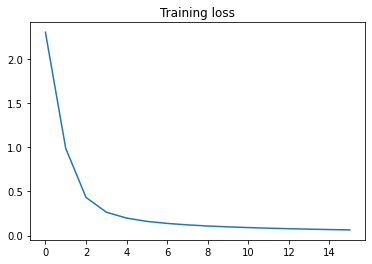

In [55]:
plt.plot(losses)
plt.title("Training loss");

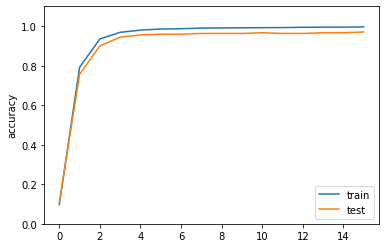

In [56]:
plt.plot(accuracies, label = 'train')
plt.plot(accuracies_test, label = 'test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc = 'best');

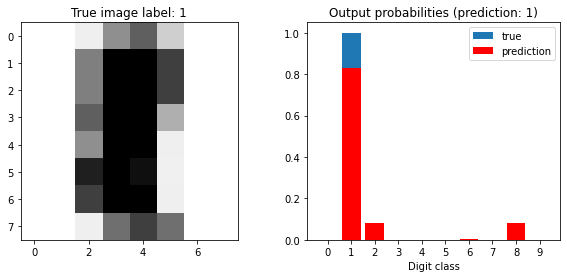

In [60]:
plot_prediction(model, sample_idx = 5)

- Look at worst prediction errors:

    - Use numpy to find test samples for which the model made the worst predictions,
    - Use the `plot_prediction` to look at the model predictions on those,
    - Would you have done any better?

In [58]:
np.where(model.predict(X_test) != y_test)

(array([ 99, 107, 143, 170, 173, 212, 219, 244]),)

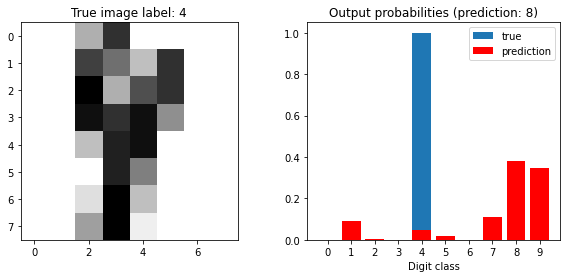

In [61]:
plot_prediction(model, sample_idx = 99)

### Back to Keras

- You can now use keras to implement and train the same network architecture

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

n_features = 8 * 8
n_classes = 10
n_hidden = 10

keras_model = Sequential()
#couche dense: Tous les input sont entierement connectés à tous les output
keras_model.add(Dense(n_hidden, input_dim = n_features, activation = 'sigmoid'))
keras_model.add(Dense(n_classes, activation = 'softmax'))

#optimizer: descent de gradient
#Compile : Calculer la dérivé et définir la rétropropagation du gradient
keras_model.compile(optimizer = SGD(learning_rate = 3),
                    loss='categorical_crossentropy', metrics=['accuracy'])

keras_model.fit(X_train, to_categorical(y_train), epochs = 15, batch_size = 16) 

Epoch 1/15
96/96 [==============================] - 0s 863us/step - loss: 0.6883 - accuracy: 0.7996
Epoch 2/15
96/96 [==============================] - 0s 841us/step - loss: 0.2122 - accuracy: 0.9417
Epoch 3/15
96/96 [==============================] - 0s 734us/step - loss: 0.1510 - accuracy: 0.9555
Epoch 4/15
96/96 [==============================] - 0s 794us/step - loss: 0.0944 - accuracy: 0.9771
Epoch 5/15
96/96 [==============================] - 0s 675us/step - loss: 0.1129 - accuracy: 0.9640
Epoch 6/15
96/96 [==============================] - 0s 714us/step - loss: 0.0874 - accuracy: 0.9699
Epoch 7/15
96/96 [==============================] - 0s 742us/step - loss: 0.0701 - accuracy: 0.9836
Epoch 8/15
96/96 [==============================] - 0s 703us/step - loss: 0.0451 - accuracy: 0.9921
Epoch 9/15
96/96 [==============================] - 0s 724us/step - loss: 0.0331 - accuracy: 0.9941
Epoch 10/15
96/96 [==============================] - 0s 714us/step - loss: 0.0233 - accuracy: 0.9974

- Using keras, add a second hidden Layer to keras_model model and learn the hyper parameters.

In [67]:
keras_model = Sequential()
#le input_dim a seulement besoin d'être préciser lors de la 1er couche
keras_model.add(Dense(n_hidden, input_dim = n_features, activation = 'sigmoid'))
keras_model.add(Dense(n_hidden, activation = 'sigmoid'))
keras_model.add(Dense(n_classes, activation = 'softmax'))

keras_model.compile(optimizer = SGD(learning_rate = 3),
                    loss='categorical_crossentropy', metrics=['accuracy'])

keras_model.fit(X_train, to_categorical(y_train), epochs = 50, batch_size = 16) 

Epoch 1/50
96/96 [==============================] - 0s 636us/step - loss: 1.2995 - accuracy: 0.5141
Epoch 2/50
96/96 [==============================] - 0s 777us/step - loss: 0.4566 - accuracy: 0.8585
Epoch 3/50
96/96 [==============================] - 0s 775us/step - loss: 0.3157 - accuracy: 0.9103
Epoch 4/50
96/96 [==============================] - 0s 761us/step - loss: 0.2345 - accuracy: 0.9332
Epoch 5/50
96/96 [==============================] - 0s 807us/step - loss: 0.2366 - accuracy: 0.9312
Epoch 6/50
96/96 [==============================] - 0s 860us/step - loss: 0.2051 - accuracy: 0.9443
Epoch 7/50
96/96 [==============================] - 0s 835us/step - loss: 0.1847 - accuracy: 0.9476
Epoch 8/50
96/96 [==============================] - 0s 827us/step - loss: 0.1305 - accuracy: 0.9646
Epoch 9/50
96/96 [==============================] - 0s 836us/step - loss: 0.1457 - accuracy: 0.9555
Epoch 10/50
96/96 [==============================] - 0s 790us/step - loss: 0.1381 - accuracy: 0.9581

- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 50 or more if necessary).

On commence à overfitting